In [13]:
# Dependencies
import pandas as pd
import requests
import json
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np

# Google API Key (maybe later)
from config import gkey


In [14]:
# Source files
attendance_raw = 'Resources/national_park_attendance_Prev3Y.xlsx'
park_info = 'Resources/national_park_locations.xlsx'
state_orders = 'Resources/state_orders.xlsx'
#wildfires = 'Resources/California_Fire_Incidents.csv'

# Read data and store in dataframe
attendance_data = pd.read_excel(attendance_raw)
park_info_data = pd.read_excel(park_info)
emergency_orders_data = pd.read_excel(state_orders)
#wildfire_data = pd.read_csv(wildfires)


In [15]:
# Limit park info dataframe to West Coast
national_parks = park_info_data.loc[(park_info_data['ParkType']=='National Park')]
focus_parks = pd.DataFrame(national_parks.loc[(park_info_data['State'] == 'CA') | (park_info_data['State'] == 'OR') | (park_info_data['State'] == 'WA')])
focus_parks.reset_index()

#focus_parks['FullName'] = focus_parks['Park']

# Create new 'FullName' column (empty)
focus_parks['FullName'] = focus_parks['Park'].str.replace(['NP'],'')#+focus_parks['ParkType'])

focus_parks['FullName']=focus_parks['Park'].str[:-2]+focus_parks['ParkType']

#focus_parks['Park'].replace('NP', 'National Park', inplace=True)
#focus_parks['Park'] = focus_parks['Park'].str.replace('NP','')

focus_parks.head(20)

,Park,UnitCode,ParkType,Region,State,FullName
63,Channel Islands NP,CHIS,National Park,Pacific West,CA,Channel Islands National Park
79,Crater Lake NP,CRLA,National Park,Pacific West,OR,Crater Lake National Park
87,Death Valley NP,DEVA,National Park,Pacific West,CA,Death Valley National Park
191,Joshua Tree NP,JOTR,National Park,Pacific West,CA,Joshua Tree National Park
198,Kings Canyon NP,KICA,National Park,Pacific West,CA,Kings Canyon National Park
210,Lassen Volcanic NP,LAVO,National Park,Pacific West,CA,Lassen Volcanic National Park
244,Mount Rainier NP,MORA,National Park,Pacific West,WA,Mount Rainier National Park
262,North Cascades NP,NOCA,National Park,Pacific West,WA,North Cascades National Park
265,Olympic NP,OLYM,National Park,Pacific West,WA,Olympic National Park
281,Pinnacles NP,PINN,National Park,Pacific West,CA,Pinnacles National Park


In [16]:
# Limit emergency order dataframe to West Coast
all_orders = pd.DataFrame(emergency_orders_data.loc[(emergency_orders_data['policy_level'] == 'state') & (emergency_orders_data['start_stop'] == 'start')])
emergency_orders = pd.DataFrame(all_orders.loc[(all_orders['policy_type'] == 'Entertainment') | (all_orders['policy_type'] == 'Food and Drink') | (all_orders['policy_type'] == 'Gyms') | (all_orders['policy_type'] == 'Non-Essential Businesses')])
state_policy = pd.DataFrame(emergency_orders.loc[(emergency_orders['state_id'] == 'CA') | (emergency_orders['state_id'] == 'OR') | (emergency_orders['state_id'] == 'WA')])
emergency_orders.reset_index()

emergency_orders.head(20)

,state_id,county,fips_code,policy_level,date,policy_type,start_stop,comments,source,total_phases
5,IA,NaN,NaN,state,2020-06-12,Gyms,start,Policy_Details: Social Distancing Source inf...,sip_submission_form: https://quincy-network.s3...,NaN
8,ID,NaN,NaN,state,2020-05-01,Non-Essential Businesses,start,"Policy_Details: ""Indoor gyms and recreation fa...",sip_submission_form: https://rebound.idaho.gov...,NaN
74,OH,NaN,NaN,state,2020-05-01,Non-Essential Businesses,start,"Policy_Details: hair salons, day spas, nail sa...",sip_submission_form: https://coronavirus.ohio....,NaN
99,WY,NaN,NaN,state,2020-05-15,Food and Drink,start,Policy_Details: Ease restrictions on several b...,sip_submission_form: https://health.wyo.gov/re...,NaN
104,MD,NaN,NaN,state,2020-06-19,Gyms,start,"Policy_Details: Fitness centers, health clubs,...",sip_submission_form: https://governor.maryland...,NaN
137,ID,NaN,NaN,state,2020-03-25,Gyms,start,Other measures and details for this policy inc...,BU COVID-19 State Policy Database,NaN
194,NM,NaN,NaN,state,2020-03-19,Gyms,start,Other measures and details for this policy inc...,BU COVID-19 State Policy Database,NaN
206,NV,NaN,NaN,state,2020-03-21,Gyms,start,Other measures and details for this policy inc...,BU COVID-19 State Policy Database,NaN
209,HI,NaN,NaN,state,2020-05-07,Entertainment,start,"Policy_Details: ""Under Phase 1 of the state’s ...",sip_submission_form: https://governor.hawaii.g...,NaN
227,AZ,NaN,NaN,state,2020-03-31,Entertainment,start,"Policy_Details: Starting Monday, May 4, 2020, ...",sip_submission_form: https://azgovernor.gov/si...,NaN


In [17]:
# Find the geocoordinates (latitude and longitude)
park = "Yellowstone"

params = {"address": park, "key": gkey}

# Build URL using the Google Maps API
base_url = "https://maps.googleapis.com/maps/api/geocode/json"

#print("Drill #1: The Geocoordinates of X")

# Run request
response = requests.get(base_url, params=params)

# print the response URL, avoid doing for public GitHub repos in order to avoid exposing key
# print(response.url)

# Convert to JSON
park_geo = response.json()

# Extract lat/lng
lat = park_geo["results"][0]["geometry"]["location"]["lat"]
lng = park_geo["results"][0]["geometry"]["location"]["lng"]

# Print results
print(f"{park}: {lat}, {lng}")

Yellowstone: 44.427963, -110.588455


In [18]:
# Build URL using the Google Maps API

lats=[]
longs=[]
cost=[]

base_url = "https://maps.googleapis.com/maps/api/geocode/json"

for Park in focus_parks['FullName']:
    params = {"address": Park, "key": gkey}
    response = requests.get(base_url, params=params)
    park_geo = response.json()
    lats.append(park_geo["results"][0]["geometry"]["location"]["lat"])
    longs.append(park_geo["results"][0]["geometry"]["location"]["lng"])           
    

In [19]:
# Add geocoordinates to dataframe
focus_parks['Latitude']=lats
focus_parks['Longitude']=longs
focus_parks.head()

,Park,UnitCode,ParkType,Region,State,FullName,Latitude,Longitude
63,Channel Islands NP,CHIS,National Park,Pacific West,CA,Channel Islands National Park,34.006936,-119.778533
79,Crater Lake NP,CRLA,National Park,Pacific West,OR,Crater Lake National Park,42.868441,-122.168479
87,Death Valley NP,DEVA,National Park,Pacific West,CA,Death Valley National Park,36.505389,-117.079408
191,Joshua Tree NP,JOTR,National Park,Pacific West,CA,Joshua Tree National Park,33.873415,-115.900992
198,Kings Canyon NP,KICA,National Park,Pacific West,CA,Kings Canyon National Park,36.887855,-118.555148


In [20]:
# Combine the data into a single dataframe  
park_data = pd.merge(focus_parks, attendance_data, how="left", on=["Park", "Park"])
park_data.head()

,Park,UnitCode,ParkType,Region,State,FullName,Latitude,Longitude,Code,Month,Visitors
0,Channel Islands NP,CHIS,National Park,Pacific West,CA,Channel Islands National Park,34.006936,-119.778533,CHIS,2020-01-01,19555.0
1,Channel Islands NP,CHIS,National Park,Pacific West,CA,Channel Islands National Park,34.006936,-119.778533,CHIS,2020-02-01,19682.0
2,Channel Islands NP,CHIS,National Park,Pacific West,CA,Channel Islands National Park,34.006936,-119.778533,CHIS,2020-03-01,9913.0
3,Channel Islands NP,CHIS,National Park,Pacific West,CA,Channel Islands National Park,34.006936,-119.778533,CHIS,2020-04-01,113.0
4,Channel Islands NP,CHIS,National Park,Pacific West,CA,Channel Islands National Park,34.006936,-119.778533,CHIS,2020-05-01,1618.0


In [21]:
park_data['Calendar Year'] = pd.DatetimeIndex(park_data['Month']).year
park_data['Calendar Month'] = pd.DatetimeIndex(park_data['Month']).month

park_data = park_data.set_index('FullName')

park_data.head(50)

,Park,UnitCode,ParkType,Region,State,Latitude,Longitude,Code,Month,Visitors,Calendar Year,Calendar Month
FullName,,,,,,,,,,,,
Channel Islands National Park,Channel Islands NP,CHIS,National Park,Pacific West,CA,34.006936,-119.778533,CHIS,2020-01-01,19555.0,2020,1
Channel Islands National Park,Channel Islands NP,CHIS,National Park,Pacific West,CA,34.006936,-119.778533,CHIS,2020-02-01,19682.0,2020,2
Channel Islands National Park,Channel Islands NP,CHIS,National Park,Pacific West,CA,34.006936,-119.778533,CHIS,2020-03-01,9913.0,2020,3
Channel Islands National Park,Channel Islands NP,CHIS,National Park,Pacific West,CA,34.006936,-119.778533,CHIS,2020-04-01,113.0,2020,4
Channel Islands National Park,Channel Islands NP,CHIS,National Park,Pacific West,CA,34.006936,-119.778533,CHIS,2020-05-01,1618.0,2020,5
Channel Islands National Park,Channel Islands NP,CHIS,National Park,Pacific West,CA,34.006936,-119.778533,CHIS,2020-06-01,7088.0,2020,6
Channel Islands National Park,Channel Islands NP,CHIS,National Park,Pacific West,CA,34.006936,-119.778533,CHIS,2020-07-01,9999.0,2020,7
Channel Islands National Park,Channel Islands NP,CHIS,National Park,Pacific West,CA,34.006936,-119.778533,CHIS,2020-08-01,11694.0,2020,8
Channel Islands National Park,Channel Islands NP,CHIS,National Park,Pacific West,CA,34.006936,-119.778533,CHIS,2020-09-01,8487.0,2020,9


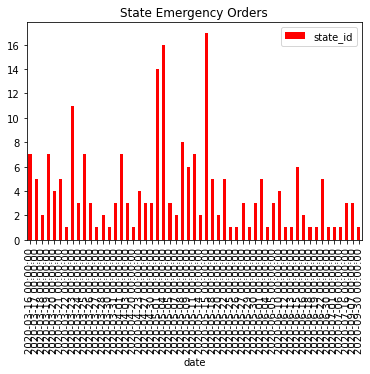

In [22]:
# Generate a bar plot for state orders 
ugh_group = emergency_orders.groupby('date')
measures = pd.DataFrame(ugh_group['state_id'].count())

state_order_chart=measures.plot(kind='bar', title='State Emergency Orders', color='red')

plt.show()

In [23]:
%pylab inline

df2 = df.groupby(['Name', 'Abuse/NFF'])['Name'].count().unstack('Abuse/NFF').fillna(0)
df2[['abuse','nff']].plot(kind='bar', stacked=True)

Populating the interactive namespace from numpy and matplotlib


NameError: name 'df' is not defined

In [ ]:
# Generate a bar plot for visitors by month 
argh_group = park_data.groupby('Month')
measures = pd.DataFrame(argh_group['Visitors'].sum())

drug_chart=measures.plot(kind='bar', title='National Park Visitors', color='navy')

drug_chart.set_xlabel('Month')
drug_chart.set_ylabel('Total Visitors')

plt.show()

In [ ]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the visutors for each calendar year
# Use groupby and summary statistical methods to calculate the following properties of each drug regimen: 
# mean, median, variance, standard deviation, and SEM of the tumor volume. 


mean = park_data.groupby('Calendar Year').mean()['Visitors']
median = park_data.groupby('Calendar Year').median()['Visitors']
variance = park_data.groupby('Calendar Year').var()['Visitors']
std_dev = park_data.groupby('Calendar Year').std()['Visitors']
SEM = park_data.groupby('Calendar Year').sem()['Visitors']

# Assemble the resulting series into a single summary dataframe.
park_stats = pd.DataFrame({'Mean': mean,
              'Median':median,
              'Variance': variance,
              'Standard Deviation': std_dev,
                         'SEM':SEM})
park_stats.head(12)

In [ ]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen
# Using the aggregation method, produce the same summary statistics in a single line
# Google take the wheel ...
summary_stats= park_data.groupby('Park').agg({'Visitors':['mean','median','var','std','sem']})
summary_stats

In [26]:
# Split up our data into groups based upon 'Calendar Year' and 'Calendar Month'
year_groups = park_data.groupby(['Calendar Year','Calendar Month'])

# Create a new variable that holds the sum of our groups
monthly_summary = year_groups.sum()
monthly_summary.head(50)


Latitude    Longitude   Visitors
Calendar Year Calendar Month                                    
2017          1               520.148799 -1564.824142   662187.0
              2               520.148799 -1564.824142   671480.0
              3               520.148799 -1564.824142   992657.0
              4               520.148799 -1564.824142  1266715.0
              5               520.148799 -1564.824142  1637021.0
              6               520.148799 -1564.824142  2061602.0
              7               520.148799 -1564.824142  2585434.0
              8               520.148799 -1564.824142  2707533.0
              9               520.148799 -1564.824142  1970603.0
              10              520.148799 -1564.824142  1346373.0
              11              520.148799 -1564.824142   936351.0
              12              520.148799 -1564.824142   760783.0
2018          1               520.148799 -1564.824142   789501.0
              2               520.148799 -1564.824142   808170.0
              3               520.148799 -1564.824142  1064691.0
              4               520.148799 -1564.824142  1195308.0
              5               520.148799 -1564.824142  1608871.0
              6               520.148799 -1564.824142  2065430.0
              7               520.148799 -1564.824142  2374889.0
              8               520.148799 -1564.824142  2393532.0
              9               520.148799 -1564.824142  1871944.0
              10              520.148799 -1564.824142  1379187.0
              11              520.148799 -1564.824142   993563.0
              12              520.148799 -1564.824142   958072.0
2019          1               520.148799 -1564.824142   605921.0
              2               520.148799 -1564.824142   670046.0
              3               520.148799 -1564.824142  1155917.0
              4               520.148799 -1564.824142  1290567.0
              5               520.148799 -1564.824142  1582516.0
              6               520.148799 -1564.824142  2081930.0
              7               520.148799 -1564.824142  2624976.0
              8               520.148799 -1564.824142  2805117.0
              9               520.148799 -1564.824142  2014533.0
              10              520.148799 -1564.824142  1474949.0
              11              520.148799 -1564.824142   989485.0
              12              520.148799 -1564.824142   833321.0
2020          1               520.148799 -1564.824142   732397.0
              2               520.148799 -1564.824142   819186.0
              3               520.148799 -1564.824142   550521.0
              4               520.148799 -1564.824142    66384.0
              5               520.148799 -1564.824142   150094.0
              6               520.148799 -1564.824142  1046707.0
              7               520.148799 -1564.824142  2185952.0
              8               520.148799 -1564.824142  2309622.0
              9               520.148799 -1564.824142  1065666.0
              10              520.148799 -1564.824142  1091669.0
              11              520.148799 -1564.824142  1034168.0

KeyError: 'Column not found: visitors'

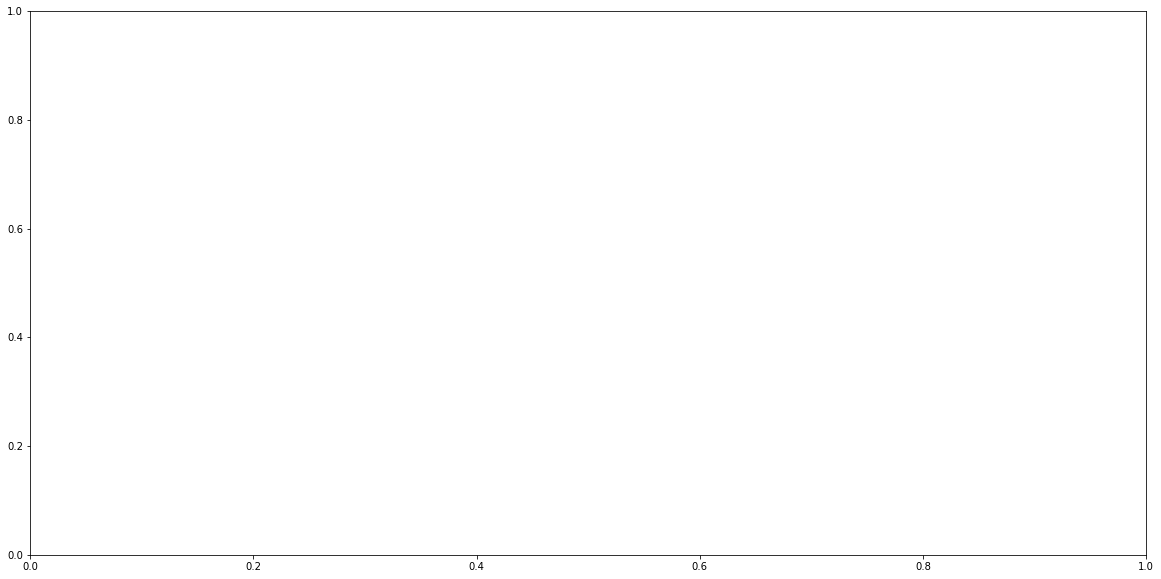

In [28]:
# Create a boxplot to compare means
monthly_summary.boxplot("visitors", by="Calendar Year", figsize=(20, 10))

In [24]:
monthly_summary.linegraph("visitors", by = "Calendar Year", figsize=(20, 10)")

SyntaxError: EOL while scanning string literal (<ipython-input-24-6c864bb8db5a>, line 1)